# 1.Executive summary
Since the era of automation and globalization, there has been a explosively increase in the whole food supply chain. However, serious issues arise along with the quantity of food production. Using forbiddened and harmful chemicals has become the secret of making profits for some catering business. Most of these chemicals causes human to have various deceases and canner is a large portion among them.

Therefore, in our project, **we aim to figure out whether poor food inspection results will be a factor of causes of cancer incidences. More specifically, we want to prevent the increase of cancer incidences at the very beginning by suggesting policies according to our predictions.**

We notice that whether food establishment inspection have critical violences is predictable given the details of the inspection, such as food service description and number of non-critical issues reported. Therefore we will be able to foresee that whether a new restaurant that is going to open is safe. Then by finding relations between the inspection results and cancer incidences, we can draw a prediction that whether the opening a new restaurant will lead to the increase of cancer incidences.

As a result of our investigation, we find out that food establishment destriptions and numbers of non-critical reports have a high weight in determining potential inspection results. Moreever, the number of restauratants with critical violations have a positive relation with the cancer incidences.


# 2. Data Preparation
## 2.1 Import Libraries
Firstly import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
import datetime
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, KFold

sns.set(style='white', context='notebook', palette='deep')


## 2.2 Import data from csv files
Read the provided csv files and genereate corresponding data frame

In [2]:
data_dir = './data/'
three11_service = '311_service_requests.csv'
food_inspection = 'food_establishment_inspections.csv'
community_health = 'community_health.csv'

#three11_df = pd.read_csv(data_dir + three11_service)
food_df = pd.read_csv(data_dir + food_inspection, engine='python', nrows=10000)
health_df = pd.read_csv(data_dir + community_health)

## 2.3 Helper functions
Wrote two helper functions for understanding and interpreting zip codes

In [3]:
# Helper function
def zip_to_county(zipcode, df):
    temp_df = df[df['ZIP Code'] == zipcode]
    return temp_df['County Code'].tolist()[0]

def dateToTimestamp(dateString):
    return time.mktime(datetime.datetime.strptime(dateString, "%m/%d/%y").timetuple())

county_list = ['ALBANY', 'ALLEGANY', 'BROOME', 'CATTARAUGUS', 'CAYUGA', 'CHAUTAUQUA',
       'CHEMUNG', 'CHENANGO', 'CLINTON', 'COLUMBIA', 'CORTLAND', 'DELAWARE',
       'DUTCHESS', 'ESSEX', 'FRANKLIN', 'FULTON', 'GENESEE', 'GREENE',
       'HAMILTON', 'HERKIMER', 'JEFFERSON', 'LEWIS', 'LIVINGSTON', 'MADISON',
       'MONROE', 'MONTGOMERY', 'NASSAU', 'NIAGARA', 'ONEIDA', 'ONONDAGA',
       'ONTARIO', 'ORANGE', 'ORLEANS', 'OSWEGO', 'OTSEGO', 'PUTNAM',
       'RENSSELAER', 'ROCKLAND', 'SARATOGA', 'SCHENECTADY', 'SCHOHARIE',
       'SCHUYLER', 'SENECA', 'ST LAWRENCE', 'STEUBEN', 'SULLIVAN', 'TIOGA',
       'TOMPKINS', 'ULSTER', 'WARREN', 'WASHINGTON', 'WAYNE', 'WESTCHESTER',
       'WYOMING', 'YATES']

## 2.4 Community Health Data
We will be analyzing the health information related to all cancer incidences. These data are extracted from the community health data.

Because 'low_limit_95p_CI', 'upp_limit_95p_CI', and 'data_comment' columns are empty, we drop these columns.

Reset index for extracted data as their ids are no longer valid

In [4]:
# Health Section
temp_cancer_df = health_df.loc[health_df['indicator'] == 'All cancer incidence rate per 100,000']
cancer_df = temp_cancer_df.drop(['low_limit_95p_CI', 'upp_limit_95p_CI', 'data_comment'], axis=1)
cancer_df = cancer_df.reset_index()

Numerical data of cancer incidence data

In [5]:
cancer_df.describe()

,index,event_count,avg_num_of_denominator,precent_or_rate
count,74.000000,74.000000,7.400000e+01,74.000000
mean,7882.675676,13054.878378,7.901502e+05,610.686486
std,42.752588,40044.758497,2.470534e+06,77.186943
min,7567.000000,137.000000,4.808000e+03,430.300000
25%,7868.250000,1106.250000,6.052425e+04,574.050000
50%,7886.500000,1967.000000,1.152410e+05,616.650000
75%,7904.750000,8147.000000,4.629005e+05,654.550000
max,7923.000000,322131.000000,1.949037e+07,949.900000


## 2.5 Food Establishment Inspection Data

In [6]:
food_df.describe()

,num_critical,num_critical_not_corrected,num_noncritical,nys_inspection_id,latitude,longitude,Unnamed: 23,Unnamed: 24
count,9781.000000,9778.000000,9786.000000,10000.000000,8481.000000,8481.000000,0.0,0.0
mean,0.842347,0.051033,5.707030,520027.827000,42.097561,-74.822515,NaN,NaN
std,1.492274,0.299933,5.620288,199804.441676,1.427760,2.230381,NaN,NaN
min,0.000000,0.000000,0.000000,251122.000000,0.000000,-79.757177,NaN,NaN
25%,0.000000,0.000000,2.000000,324029.750000,41.043085,-76.018072,NaN,NaN
50%,0.000000,0.000000,4.000000,522487.000000,42.097436,-73.965779,NaN,NaN
75%,1.000000,0.000000,8.000000,700404.750000,43.029350,-73.733641,NaN,NaN
max,30.000000,6.000000,71.000000,978995.000000,44.991485,0.000000,NaN,NaN


### 2.5.1 Restaurant Chains 
We notice that there are restaurant chains in the list and restaurants from the same chains tends to have similar inspection results

In [7]:
# Food Inspection
food_df['facility'].str.upper().value_counts()

DUNKIN DONUTS                           154
SUBWAY                                   54
MOE'S SOUTHWEST GRILL                    23
SHISH KEBAB SNACK BAR & RESTAURANT       21
MCDONALD'S                               20
MOUNT KISCO COACH DINER                  18
CHILI'S GRILL & BAR                      17
SAFFRON FINE INDIAN CUISINE              17
DOMINO'S PIZZA                           16
CASABLANCA RESTAURANT                    16
MINT                                     16
SHOYU JAPAN AT CRYSTAL RUN               16
MAIN STREET PIZZA                        15
INN AT SPECULATOR, THE                   15
GREAT WALL                               15
ROYAL PALACE                             15
MAMA LUCIA                               14
THAI ANGEL FUSION RESTAURANT             14
TRATTORIA LUCIA                          14
GRAND CENTRAL MARKET                     14
FRANKIE & JOHNNIE'S PIZZERIA             14
NO. A-1 ORIENTAL KITCHEN                 14
MUMBAI SPICES                   

### 2.5.2 Preprocess and enumerate data entries
We fill in NaN entries with -1 to indicate missing values.

Because 'facility', 'address', 'local_health_department', 'city', 'zipcode', 'municipality', 'nys_inspection_id', 'facility_code', 'latitude', 'longitude', 'permit_expiration_date' are less relavent to the problem, we drop them.

'violation_description', 'inspection_comments' can be very inefficient if they were to be represeneted numercially because they are mostly unique. So we drop them as well.


In [8]:
processed_food_df = food_df
# Fill empty and NaNs values with NaN
processed_food_df = processed_food_df.fillna(-1)
processed_food_df = processed_food_df.drop(['facility','address','violation_description','local_health_department', \
                                            'city','zipcode','municipality','nys_inspection_id', 'facility_code', \
                                            'inspection_comments','latitude','longitude', 'permit_expiration_date', \
                                            'Unnamed: 23', 'Unnamed: 24'], axis=1).reset_index(drop=True)

We notice that data of each column are in various types. In order to analyze the data numerically, we find mappings of non-number types to number types (either int or float), as shown below for an example of the mappings.

In [9]:
processed_food_df['violation_item'] = processed_food_df['violation_item'].astype('category')
processed_food_df['violation_item'] = processed_food_df['violation_item'].cat.codes

processed_food_df['critical_violation'] = processed_food_df['critical_violation'].astype('category')
processed_food_df['critical_violation'] = processed_food_df['critical_violation'].cat.codes

processed_food_df['county'] = processed_food_df['county'].astype('category')
processed_food_df['county'] = processed_food_df['county'].cat.codes

processed_food_df['food_service_type'] = processed_food_df['food_service_type'].astype('category')
processed_food_df['food_service_type'] = processed_food_df['food_service_type'].cat.codes

processed_food_df['food_service_description'] = processed_food_df['food_service_description'].astype('category')
processed_food_df['food_service_description'] = processed_food_df['food_service_description'].cat.codes

processed_food_df['inspection_type'] = processed_food_df['inspection_type'].astype('category')
processed_food_df['inspection_type'] = processed_food_df['inspection_type'].cat.codes

processed_food_df['inspection_date'] = processed_food_df['inspection_date'].apply(dateToTimestamp)

processed_food_df.head(10)

,inspection_date,violation_item,critical_violation,num_critical,num_critical_not_corrected,num_noncritical,county,food_service_type,food_service_description,inspection_type
0,1.507003e+09,16,1,0.0,0.0,3.0,27,0,15,0
1,1.441771e+09,1,1,0.0,0.0,1.0,35,0,14,0
2,1.271304e+09,60,1,0.0,0.0,0.0,37,0,8,0
3,1.342066e+09,60,1,0.0,0.0,0.0,42,0,1,0
4,1.314331e+09,60,1,0.0,0.0,0.0,47,0,15,1
5,1.485407e+09,16,1,0.0,0.0,4.0,48,0,8,0
6,1.430107e+09,4,1,0.0,0.0,9.0,48,0,8,0
7,1.326258e+09,50,1,1.0,0.0,4.0,48,0,8,0
8,1.360818e+09,13,1,0.0,0.0,20.0,48,0,8,0
9,1.138079e+09,60,1,-1.0,-1.0,-1.0,30,0,8,0


### 2.5.3 Normalize and Standarize numerical data
From 2.5.2, we successfully represent all data in numbers. However, these numbers are significantly imbalanced, which may cause issues in prodicting process and other analysis. Thus, we furtherly modified the data with standarization as well as normalization. 

For each column $\mathbf{x} = \begin{bmatrix} x_1 \\ x_2 \\ \cdots \\ x_N \end{bmatrix}$, we applied $x_i = \frac{x_i - \bar{x}}{\sigma}$ to each entry, which achieved feature centering and scaling.

After standarization, we applied $x_i = \frac{x_i - \min{x}}{\max{x} - \min{x}}$ so that each entries falled into range from $[0, 1]$ to accomplish normalization.

In [10]:
# Normolization standarization
#processed_food_df['inspection_date'].plot(kind='bar')

# Create x, where x the 'scores' column's values as floats
x1 = processed_food_df[['inspection_date']].values.astype(float)
x2 = processed_food_df[['violation_item']].values.astype(float)
x3 = processed_food_df[['critical_violation']].values.astype(float)
x4 = processed_food_df[['num_critical']].values.astype(float)
x5 = processed_food_df[['num_critical_not_corrected']].values.astype(float)
x6 = processed_food_df[['num_noncritical']].values.astype(float)
x7 = processed_food_df[['county']].values.astype(float)
x8 = processed_food_df[['food_service_type']].values.astype(float)
x9 = processed_food_df[['food_service_description']].values.astype(float)
x10 = processed_food_df[['inspection_type']].values.astype(float)


# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x1_scaled = min_max_scaler.fit_transform(x1)
x2_scaled = min_max_scaler.fit_transform(x2)
x3_scaled = min_max_scaler.fit_transform(x3)
x4_scaled = min_max_scaler.fit_transform(x4)
x5_scaled = min_max_scaler.fit_transform(x5)
x6_scaled = min_max_scaler.fit_transform(x6)
x7_scaled = min_max_scaler.fit_transform(x7)
x8_scaled = min_max_scaler.fit_transform(x8)
x9_scaled = min_max_scaler.fit_transform(x9)
x10_scaled = min_max_scaler.fit_transform(x10)

# Run the normalizer on the dataframe
x1_normalized = pd.DataFrame(x1_scaled)
x2_normalized = pd.DataFrame(x2_scaled)
x3_normalized = pd.DataFrame(x3_scaled)
x4_normalized = pd.DataFrame(x4_scaled)
x5_normalized = pd.DataFrame(x5_scaled)
x6_normalized = pd.DataFrame(x6_scaled)
x7_normalized = pd.DataFrame(x7_scaled)
x8_normalized = pd.DataFrame(x8_scaled)
x9_normalized = pd.DataFrame(x9_scaled)
x10_normalized = pd.DataFrame(x10_scaled)
frames = [x1_normalized, x2_normalized, x3_normalized, x4_normalized, x5_normalized, x6_normalized, x7_normalized, x8_normalized, x9_normalized, x10_normalized]
result = pd.concat(frames,  axis=1)
result.columns = ['inspection_date', 'violation_item', 'critical_violation', 'num_critical', 'num_critical_not_corrected', 'num_noncritical', 'county', 'food_service_type', 'food_service_description', 'inspection_type']
result.head(10)

,inspection_date,violation_item,critical_violation,num_critical,num_critical_not_corrected,num_noncritical,county,food_service_type,food_service_description,inspection_type
0,0.979647,0.266667,1.0,0.032258,0.142857,0.055556,0.500000,0.0,0.652174,0.0
1,0.810858,0.016667,1.0,0.032258,0.142857,0.027778,0.648148,0.0,0.608696,0.0
2,0.369771,1.000000,1.0,0.032258,0.142857,0.013889,0.685185,0.0,0.347826,0.0
3,0.552868,1.000000,1.0,0.032258,0.142857,0.013889,0.777778,0.0,0.043478,0.0
4,0.481104,1.000000,1.0,0.032258,0.142857,0.013889,0.870370,0.0,0.652174,1.0
5,0.923766,0.266667,1.0,0.032258,0.142857,0.069444,0.888889,0.0,0.347826,0.0
6,0.780677,0.066667,1.0,0.032258,0.142857,0.138889,0.888889,0.0,0.347826,0.0
7,0.511965,0.833333,1.0,0.064516,0.142857,0.069444,0.888889,0.0,0.347826,0.0
8,0.601390,0.216667,1.0,0.032258,0.142857,0.291667,0.888889,0.0,0.347826,0.0
9,0.025048,1.000000,1.0,0.000000,0.000000,0.000000,0.555556,0.0,0.347826,0.0


# 3. Predicting Food Establishment Violations
Given our preprocessed data, we are hopping to  predict food establishment violations throught selected features below:
* num_critical
* num_critical_not_corrected
* num_noncritical
* food_service_type 
* food_service_description
* inspection_type


## 3.1 K nearest neighbour

K nearest neighbour was the very first algorithm that came into our mind when it comes to classification. It's very efficient when it comes to large data processing.

We applied cross validation in to our machine training model to validate our accuracy. At the end, we KNN finished with an accuracy of 90%

In [11]:
X_train_set = (result[['num_critical', 'num_critical_not_corrected', 'num_noncritical', 'food_service_type', 'food_service_description', 'inspection_type']])
y_train_set = (result[['critical_violation']])
kf = KFold(n_splits=10, shuffle=False)
kf.get_n_splits(X_train_set)
for train_index, test_index in kf.split(X_train_set):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_train_set.iloc[train_index], X_train_set.iloc[test_index]
    y_train, y_test = y_train_set.iloc[train_index], y_train_set.iloc[test_index]
    
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, y_train)
    Y_pred = knn.predict(X_test)
    accuracy_knn = round(knn.score(X_train, y_train) * 100, 2)
    print("Current accuracy: " + str(accuracy_knn))

TRAIN: [1000 1001 1002 ... 9997 9998 9999] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 2

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Current accuracy: 90.08
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013
 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027
 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041
 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055
 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069
 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083
 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097
 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 1110 1111
 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124 1125
 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138 1139
 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152 1153
 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166 1167
 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181
 118

Current accuracy: 90.26
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [3000 3001 3002 3003 3004 3005 3006 3007 3008 3009 3010 3011 3012 3013
 3014 3015 3016 3017 3018 3019 3020 3021 3022 3023 3024 3025 3026 3027
 3028 3029 3030 3031 3032 3033 3034 3035 3036 3037 3038 3039 3040 3041
 3042 3043 3044 3045 3046 3047 3048 3049 3050 3051 3052 3053 3054 3055
 3056 3057 3058 3059 3060 3061 3062 3063 3064 3065 3066 3067 3068 3069
 3070 3071 3072 3073 3074 3075 3076 3077 3078 3079 3080 3081 3082 3083
 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3094 3095 3096 3097
 3098 3099 3100 3101 3102 3103 3104 3105 3106 3107 3108 3109 3110 3111
 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123 3124 3125
 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137 3138 3139
 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151 3152 3153
 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165 3166 3167
 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180 3181
 318

Current accuracy: 89.83
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [5000 5001 5002 5003 5004 5005 5006 5007 5008 5009 5010 5011 5012 5013
 5014 5015 5016 5017 5018 5019 5020 5021 5022 5023 5024 5025 5026 5027
 5028 5029 5030 5031 5032 5033 5034 5035 5036 5037 5038 5039 5040 5041
 5042 5043 5044 5045 5046 5047 5048 5049 5050 5051 5052 5053 5054 5055
 5056 5057 5058 5059 5060 5061 5062 5063 5064 5065 5066 5067 5068 5069
 5070 5071 5072 5073 5074 5075 5076 5077 5078 5079 5080 5081 5082 5083
 5084 5085 5086 5087 5088 5089 5090 5091 5092 5093 5094 5095 5096 5097
 5098 5099 5100 5101 5102 5103 5104 5105 5106 5107 5108 5109 5110 5111
 5112 5113 5114 5115 5116 5117 5118 5119 5120 5121 5122 5123 5124 5125
 5126 5127 5128 5129 5130 5131 5132 5133 5134 5135 5136 5137 5138 5139
 5140 5141 5142 5143 5144 5145 5146 5147 5148 5149 5150 5151 5152 5153
 5154 5155 5156 5157 5158 5159 5160 5161 5162 5163 5164 5165 5166 5167
 5168 5169 5170 5171 5172 5173 5174 5175 5176 5177 5178 5179 5180 5181
 518

Current accuracy: 89.96
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [7000 7001 7002 7003 7004 7005 7006 7007 7008 7009 7010 7011 7012 7013
 7014 7015 7016 7017 7018 7019 7020 7021 7022 7023 7024 7025 7026 7027
 7028 7029 7030 7031 7032 7033 7034 7035 7036 7037 7038 7039 7040 7041
 7042 7043 7044 7045 7046 7047 7048 7049 7050 7051 7052 7053 7054 7055
 7056 7057 7058 7059 7060 7061 7062 7063 7064 7065 7066 7067 7068 7069
 7070 7071 7072 7073 7074 7075 7076 7077 7078 7079 7080 7081 7082 7083
 7084 7085 7086 7087 7088 7089 7090 7091 7092 7093 7094 7095 7096 7097
 7098 7099 7100 7101 7102 7103 7104 7105 7106 7107 7108 7109 7110 7111
 7112 7113 7114 7115 7116 7117 7118 7119 7120 7121 7122 7123 7124 7125
 7126 7127 7128 7129 7130 7131 7132 7133 7134 7135 7136 7137 7138 7139
 7140 7141 7142 7143 7144 7145 7146 7147 7148 7149 7150 7151 7152 7153
 7154 7155 7156 7157 7158 7159 7160 7161 7162 7163 7164 7165 7166 7167
 7168 7169 7170 7171 7172 7173 7174 7175 7176 7177 7178 7179 7180 7181
 718

Current accuracy: 89.9
TRAIN: [   0    1    2 ... 8997 8998 8999] TEST: [9000 9001 9002 9003 9004 9005 9006 9007 9008 9009 9010 9011 9012 9013
 9014 9015 9016 9017 9018 9019 9020 9021 9022 9023 9024 9025 9026 9027
 9028 9029 9030 9031 9032 9033 9034 9035 9036 9037 9038 9039 9040 9041
 9042 9043 9044 9045 9046 9047 9048 9049 9050 9051 9052 9053 9054 9055
 9056 9057 9058 9059 9060 9061 9062 9063 9064 9065 9066 9067 9068 9069
 9070 9071 9072 9073 9074 9075 9076 9077 9078 9079 9080 9081 9082 9083
 9084 9085 9086 9087 9088 9089 9090 9091 9092 9093 9094 9095 9096 9097
 9098 9099 9100 9101 9102 9103 9104 9105 9106 9107 9108 9109 9110 9111
 9112 9113 9114 9115 9116 9117 9118 9119 9120 9121 9122 9123 9124 9125
 9126 9127 9128 9129 9130 9131 9132 9133 9134 9135 9136 9137 9138 9139
 9140 9141 9142 9143 9144 9145 9146 9147 9148 9149 9150 9151 9152 9153
 9154 9155 9156 9157 9158 9159 9160 9161 9162 9163 9164 9165 9166 9167
 9168 9169 9170 9171 9172 9173 9174 9175 9176 9177 9178 9179 9180 9181
 9182

## 3.2 Random Forest
To back up our predication, we also applied another machine learning technology Random Forest, it operated by constructing a multitude of decision trees, which provides us with a stronger conclution.

Again, with the augemnt of cross validation, it predicts the violations with an accuracy at around 92%.

In [12]:
# Random Forest
kf = KFold(n_splits=10, shuffle=False)
kf.get_n_splits(X_train_set)
for train_index, test_index in kf.split(X_train_set):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_train_set.iloc[train_index], X_train_set.iloc[test_index]
    y_train, y_test = y_train_set.iloc[train_index], y_train_set.iloc[test_index]
    
    #print(y_train.shape)
    random_forest = RandomForestClassifier(n_estimators=100)
    random_forest.fit(X_train, y_train)
    
    importances = random_forest.feature_importances_
    Y_pred = random_forest.predict(X_test)
    
    random_forest.score(X_train, y_train)
    acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
    print("Current accuracy: " + str(acc_random_forest))
print(importances)

TRAIN: [1000 1001 1002 ... 9997 9998 9999] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 2

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Current accuracy: 91.61
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013
 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027
 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041
 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055
 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069
 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083
 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097
 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 1110 1111
 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124 1125
 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138 1139
 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152 1153
 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166 1167
 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181
 118

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Current accuracy: 91.57
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027
 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041
 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055
 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069
 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083
 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097
 2098 2099 2100 2101 2102 2103 2104 2105 2106 2107 2108 2109 2110 2111
 2112 2113 2114 2115 2116 2117 2118 2119 2120 2121 2122 2123 2124 2125
 2126 2127 2128 2129 2130 2131 2132 2133 2134 2135 2136 2137 2138 2139
 2140 2141 2142 2143 2144 2145 2146 2147 2148 2149 2150 2151 2152 2153
 2154 2155 2156 2157 2158 2159 2160 2161 2162 2163 2164 2165 2166 2167
 2168 2169 2170 2171 2172 2173 2174 2175 2176 2177 2178 2179 2180 2181
 218

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Current accuracy: 91.63
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [3000 3001 3002 3003 3004 3005 3006 3007 3008 3009 3010 3011 3012 3013
 3014 3015 3016 3017 3018 3019 3020 3021 3022 3023 3024 3025 3026 3027
 3028 3029 3030 3031 3032 3033 3034 3035 3036 3037 3038 3039 3040 3041
 3042 3043 3044 3045 3046 3047 3048 3049 3050 3051 3052 3053 3054 3055
 3056 3057 3058 3059 3060 3061 3062 3063 3064 3065 3066 3067 3068 3069
 3070 3071 3072 3073 3074 3075 3076 3077 3078 3079 3080 3081 3082 3083
 3084 3085 3086 3087 3088 3089 3090 3091 3092 3093 3094 3095 3096 3097
 3098 3099 3100 3101 3102 3103 3104 3105 3106 3107 3108 3109 3110 3111
 3112 3113 3114 3115 3116 3117 3118 3119 3120 3121 3122 3123 3124 3125
 3126 3127 3128 3129 3130 3131 3132 3133 3134 3135 3136 3137 3138 3139
 3140 3141 3142 3143 3144 3145 3146 3147 3148 3149 3150 3151 3152 3153
 3154 3155 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165 3166 3167
 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180 3181
 318

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Current accuracy: 91.86
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [4000 4001 4002 4003 4004 4005 4006 4007 4008 4009 4010 4011 4012 4013
 4014 4015 4016 4017 4018 4019 4020 4021 4022 4023 4024 4025 4026 4027
 4028 4029 4030 4031 4032 4033 4034 4035 4036 4037 4038 4039 4040 4041
 4042 4043 4044 4045 4046 4047 4048 4049 4050 4051 4052 4053 4054 4055
 4056 4057 4058 4059 4060 4061 4062 4063 4064 4065 4066 4067 4068 4069
 4070 4071 4072 4073 4074 4075 4076 4077 4078 4079 4080 4081 4082 4083
 4084 4085 4086 4087 4088 4089 4090 4091 4092 4093 4094 4095 4096 4097
 4098 4099 4100 4101 4102 4103 4104 4105 4106 4107 4108 4109 4110 4111
 4112 4113 4114 4115 4116 4117 4118 4119 4120 4121 4122 4123 4124 4125
 4126 4127 4128 4129 4130 4131 4132 4133 4134 4135 4136 4137 4138 4139
 4140 4141 4142 4143 4144 4145 4146 4147 4148 4149 4150 4151 4152 4153
 4154 4155 4156 4157 4158 4159 4160 4161 4162 4163 4164 4165 4166 4167
 4168 4169 4170 4171 4172 4173 4174 4175 4176 4177 4178 4179 4180 4181
 418

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Current accuracy: 91.67
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [5000 5001 5002 5003 5004 5005 5006 5007 5008 5009 5010 5011 5012 5013
 5014 5015 5016 5017 5018 5019 5020 5021 5022 5023 5024 5025 5026 5027
 5028 5029 5030 5031 5032 5033 5034 5035 5036 5037 5038 5039 5040 5041
 5042 5043 5044 5045 5046 5047 5048 5049 5050 5051 5052 5053 5054 5055
 5056 5057 5058 5059 5060 5061 5062 5063 5064 5065 5066 5067 5068 5069
 5070 5071 5072 5073 5074 5075 5076 5077 5078 5079 5080 5081 5082 5083
 5084 5085 5086 5087 5088 5089 5090 5091 5092 5093 5094 5095 5096 5097
 5098 5099 5100 5101 5102 5103 5104 5105 5106 5107 5108 5109 5110 5111
 5112 5113 5114 5115 5116 5117 5118 5119 5120 5121 5122 5123 5124 5125
 5126 5127 5128 5129 5130 5131 5132 5133 5134 5135 5136 5137 5138 5139
 5140 5141 5142 5143 5144 5145 5146 5147 5148 5149 5150 5151 5152 5153
 5154 5155 5156 5157 5158 5159 5160 5161 5162 5163 5164 5165 5166 5167
 5168 5169 5170 5171 5172 5173 5174 5175 5176 5177 5178 5179 5180 5181
 518

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Current accuracy: 91.81
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [6000 6001 6002 6003 6004 6005 6006 6007 6008 6009 6010 6011 6012 6013
 6014 6015 6016 6017 6018 6019 6020 6021 6022 6023 6024 6025 6026 6027
 6028 6029 6030 6031 6032 6033 6034 6035 6036 6037 6038 6039 6040 6041
 6042 6043 6044 6045 6046 6047 6048 6049 6050 6051 6052 6053 6054 6055
 6056 6057 6058 6059 6060 6061 6062 6063 6064 6065 6066 6067 6068 6069
 6070 6071 6072 6073 6074 6075 6076 6077 6078 6079 6080 6081 6082 6083
 6084 6085 6086 6087 6088 6089 6090 6091 6092 6093 6094 6095 6096 6097
 6098 6099 6100 6101 6102 6103 6104 6105 6106 6107 6108 6109 6110 6111
 6112 6113 6114 6115 6116 6117 6118 6119 6120 6121 6122 6123 6124 6125
 6126 6127 6128 6129 6130 6131 6132 6133 6134 6135 6136 6137 6138 6139
 6140 6141 6142 6143 6144 6145 6146 6147 6148 6149 6150 6151 6152 6153
 6154 6155 6156 6157 6158 6159 6160 6161 6162 6163 6164 6165 6166 6167
 6168 6169 6170 6171 6172 6173 6174 6175 6176 6177 6178 6179 6180 6181
 618

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Current accuracy: 91.48
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [7000 7001 7002 7003 7004 7005 7006 7007 7008 7009 7010 7011 7012 7013
 7014 7015 7016 7017 7018 7019 7020 7021 7022 7023 7024 7025 7026 7027
 7028 7029 7030 7031 7032 7033 7034 7035 7036 7037 7038 7039 7040 7041
 7042 7043 7044 7045 7046 7047 7048 7049 7050 7051 7052 7053 7054 7055
 7056 7057 7058 7059 7060 7061 7062 7063 7064 7065 7066 7067 7068 7069
 7070 7071 7072 7073 7074 7075 7076 7077 7078 7079 7080 7081 7082 7083
 7084 7085 7086 7087 7088 7089 7090 7091 7092 7093 7094 7095 7096 7097
 7098 7099 7100 7101 7102 7103 7104 7105 7106 7107 7108 7109 7110 7111
 7112 7113 7114 7115 7116 7117 7118 7119 7120 7121 7122 7123 7124 7125
 7126 7127 7128 7129 7130 7131 7132 7133 7134 7135 7136 7137 7138 7139
 7140 7141 7142 7143 7144 7145 7146 7147 7148 7149 7150 7151 7152 7153
 7154 7155 7156 7157 7158 7159 7160 7161 7162 7163 7164 7165 7166 7167
 7168 7169 7170 7171 7172 7173 7174 7175 7176 7177 7178 7179 7180 7181
 718

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Current accuracy: 91.64
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [8000 8001 8002 8003 8004 8005 8006 8007 8008 8009 8010 8011 8012 8013
 8014 8015 8016 8017 8018 8019 8020 8021 8022 8023 8024 8025 8026 8027
 8028 8029 8030 8031 8032 8033 8034 8035 8036 8037 8038 8039 8040 8041
 8042 8043 8044 8045 8046 8047 8048 8049 8050 8051 8052 8053 8054 8055
 8056 8057 8058 8059 8060 8061 8062 8063 8064 8065 8066 8067 8068 8069
 8070 8071 8072 8073 8074 8075 8076 8077 8078 8079 8080 8081 8082 8083
 8084 8085 8086 8087 8088 8089 8090 8091 8092 8093 8094 8095 8096 8097
 8098 8099 8100 8101 8102 8103 8104 8105 8106 8107 8108 8109 8110 8111
 8112 8113 8114 8115 8116 8117 8118 8119 8120 8121 8122 8123 8124 8125
 8126 8127 8128 8129 8130 8131 8132 8133 8134 8135 8136 8137 8138 8139
 8140 8141 8142 8143 8144 8145 8146 8147 8148 8149 8150 8151 8152 8153
 8154 8155 8156 8157 8158 8159 8160 8161 8162 8163 8164 8165 8166 8167
 8168 8169 8170 8171 8172 8173 8174 8175 8176 8177 8178 8179 8180 8181
 818

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Current accuracy: 91.72
TRAIN: [   0    1    2 ... 8997 8998 8999] TEST: [9000 9001 9002 9003 9004 9005 9006 9007 9008 9009 9010 9011 9012 9013
 9014 9015 9016 9017 9018 9019 9020 9021 9022 9023 9024 9025 9026 9027
 9028 9029 9030 9031 9032 9033 9034 9035 9036 9037 9038 9039 9040 9041
 9042 9043 9044 9045 9046 9047 9048 9049 9050 9051 9052 9053 9054 9055
 9056 9057 9058 9059 9060 9061 9062 9063 9064 9065 9066 9067 9068 9069
 9070 9071 9072 9073 9074 9075 9076 9077 9078 9079 9080 9081 9082 9083
 9084 9085 9086 9087 9088 9089 9090 9091 9092 9093 9094 9095 9096 9097
 9098 9099 9100 9101 9102 9103 9104 9105 9106 9107 9108 9109 9110 9111
 9112 9113 9114 9115 9116 9117 9118 9119 9120 9121 9122 9123 9124 9125
 9126 9127 9128 9129 9130 9131 9132 9133 9134 9135 9136 9137 9138 9139
 9140 9141 9142 9143 9144 9145 9146 9147 9148 9149 9150 9151 9152 9153
 9154 9155 9156 9157 9158 9159 9160 9161 9162 9163 9164 9165 9166 9167
 9168 9169 9170 9171 9172 9173 9174 9175 9176 9177 9178 9179 9180 9181
 918

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Current accuracy: 91.54
[0.50334124 0.03177629 0.37926275 0.00993639 0.06616144 0.00952188]


Here we drew a bar chart to indicate the importance of different features. According to bar chart below, we concluded that the number of critical violations was the most importent feature, its bar was significantly heigher than other features.

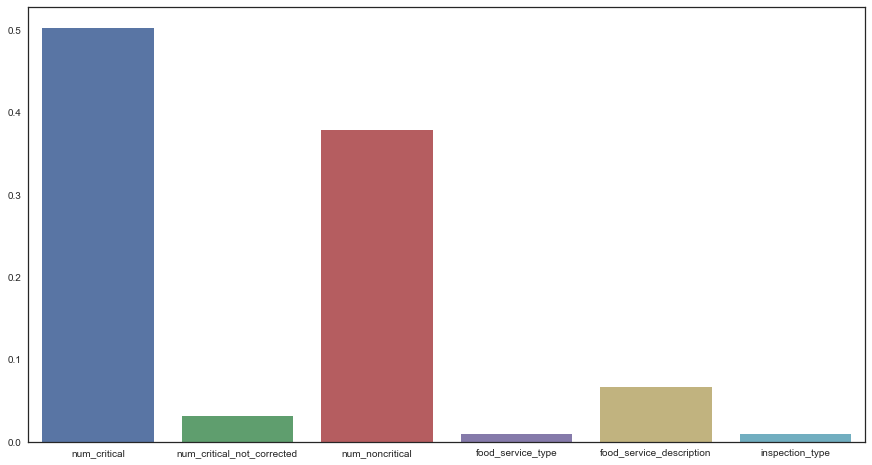

In [13]:
plt.subplots(figsize=(15,8))
ax = sns.barplot(x=['num_critical', 'num_critical_not_corrected', 'num_noncritical', 'food_service_type', 'food_service_description', 'inspection_type'], y=importances)

# 4. Relatation With Cancer Incidences
After being able to predict whether new food establishments will violate the government policies, we now investigate if these new catering bussiness will have an influence on cancer incidences.
## 4.1 Cancer Incidences in Different Counties 
In order to know a general relation between cancer incidences and food establishment inspections, we analyze within counties.

The following is a summary of cancer incidences in different counties.

It should be notied that, 'avg_num_of_denominator' is the denominator within that year. For time range from
2010~2012, we should use 3*'avg_num_of_denominator' as the real denominator to calculate the event percent. 

In [14]:
# cancer_df.head()
cancer_county_df = cancer_df[['county_name','event_count','avg_num_of_denominator','precent_or_rate']]
cancer_county_df = cancer_county_df.loc[cancer_county_df['county_name'].str.upper().isin(county_list)]
cancer_county_df = cancer_county_df.reset_index(drop=True)

cancer_county_df['event_percent'] = 3*100*cancer_county_df['event_count'].divide(cancer_county_df['avg_num_of_denominator'])
cancer_county_df.head(10)

,county_name,event_count,avg_num_of_denominator,precent_or_rate,event_percent
0,Franklin,851.0,51626.0,549.5,4.945183
1,Albany,5508.0,304694.0,602.6,5.423146
2,Allegany,911.0,48680.0,623.8,5.614215
3,Broome,3768.0,199225.0,630.4,5.673987
4,Cattaraugus,1613.0,79859.0,673.3,6.059430
5,Cayuga,1414.0,79775.0,590.8,5.317455
6,Chautauqua,2921.0,134190.0,725.6,6.530293
7,Chemung,1732.0,88848.0,649.8,5.848190
8,Chenango,1062.0,50162.0,705.7,6.351421
9,Clinton,1555.0,81862.0,633.2,5.698615


## 4.2 Food Establishment Inspection Results in Different Counties
Simiarily, we analyze the food establishment inspection results in the units of county as well.
It is apparent that the violation results vary for different counties.
One direct reason is that population is different for every county, but still, population number itself cannot explain such big food violation difference. We will explore this further in the following sections.

In [15]:
food_violation_df = processed_food_df.groupby(['county']).sum()
food_violation_df = food_violation_df['critical_violation']
food_violation = food_violation_df.tolist()
violation_per_county = zip(county_list,food_violation)

Text(0,0.5,'County')

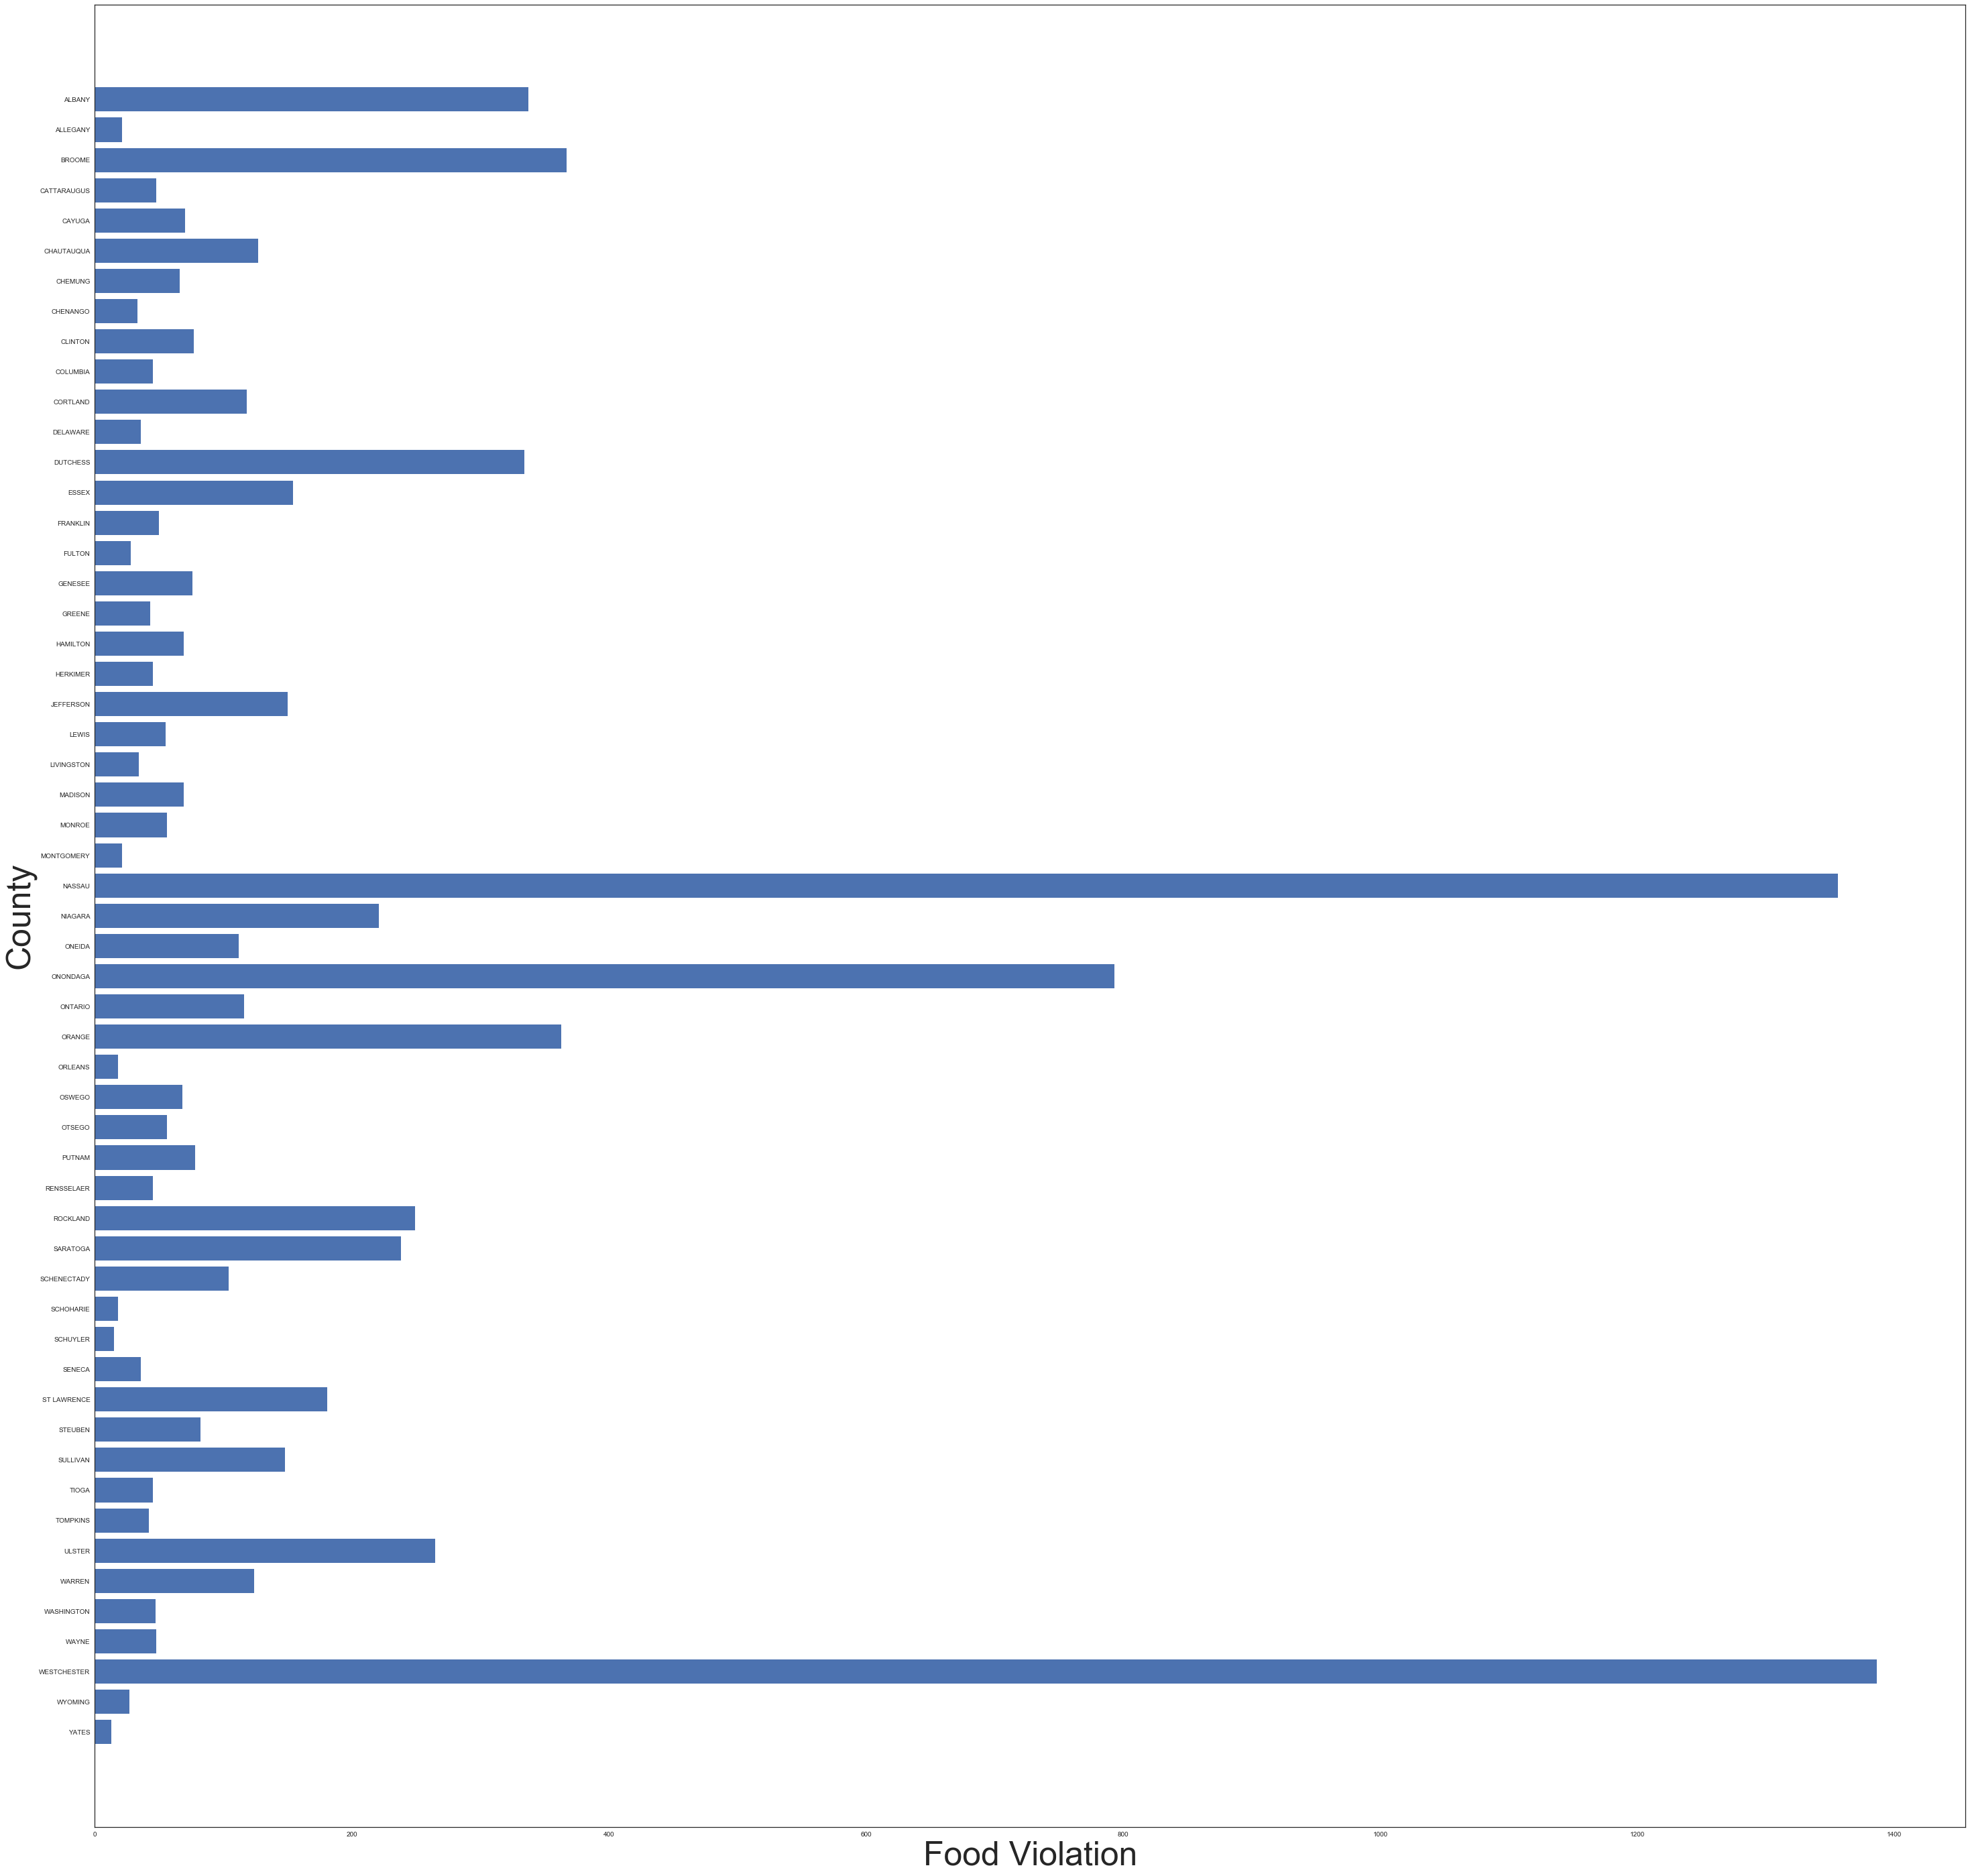

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(50, 50)
ax.barh(county_list,food_violation)
ax.invert_yaxis()
ax.set_xlabel('Food Violation', fontsize=50)
ax.set_ylabel('County', fontsize=50)

## 4.3 Correlations between Cancer Incidences and Inspection Results
After we group the inspection results by county for the Food Violation table, we join the cleaned community health table and the food inspection table. Furthermore, we calculate the violation rate of different aspects.
Using these rates and existing variables in the food table, we plot a heatmap of correlation. We hope to find valuable relationship within the correlation table.

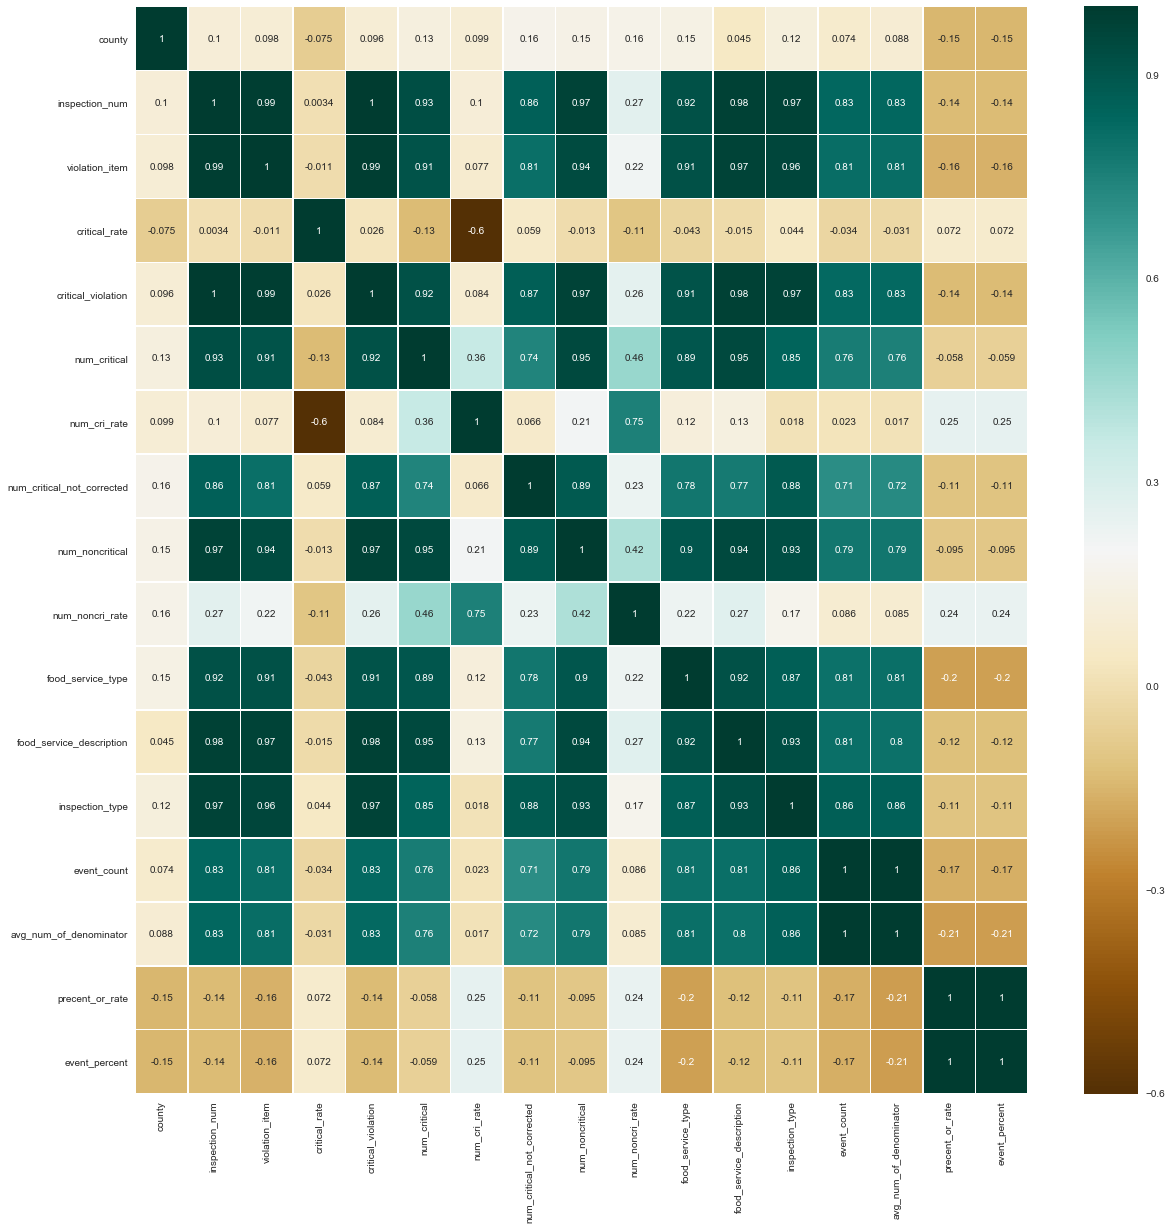

In [17]:
food_violation_df = processed_food_df.groupby(['county']).sum()

food_violation_df['inspection_num'] = processed_food_df['county'].value_counts(sort=False,ascending=True).sort_index()
food_violation_df['critical_rate'] = food_violation_df['critical_violation'].divide(food_violation_df['inspection_num'])  
food_violation_df['num_cri_rate'] = food_violation_df['num_critical'].divide(food_violation_df['inspection_num'])  
food_violation_df['num_noncri_rate'] = food_violation_df['num_noncritical'].divide(food_violation_df['inspection_num'])  

food_violation_df.drop(food_violation_df.index[43], inplace=True)
food_violation_df.reset_index(inplace=True)
food_health_df = pd.concat([food_violation_df, cancer_county_df], axis=1)
plt.subplots(figsize=(20,20))
g = sns.heatmap(food_health_df[['county','inspection_num','violation_item','critical_rate','critical_violation','num_critical','num_cri_rate', 'num_critical_not_corrected','num_noncritical','num_noncri_rate','food_service_type','food_service_description',
                                'inspection_type', 'county_name', 'event_count', 'avg_num_of_denominator', 'precent_or_rate','event_percent']].corr(),cmap="BrBG",annot=True, linewidth=.5)

From the correlation result we can obtain a lot of information. Cancer event and average denominator (popolation) is stongly related to the violation number. This is a reasonable result, as both variables are strongly affect by populations. But when it comes to the relationship between violation rate and cancer rate measures, the result is not that satisfying. The food inspection results do have influence on the cancer rate ( see the num_critical_rate, num_noncritical_rate variables), although not determining. And it totally makes sense for us to use 'critical violation' as the prediction variable. As for if we can predict whether one restaurant will violate the regulations, we can concolude what factors play important roles in the food inspection process. Therefore, we can then recommend government to take actions on these factors and furthermore, this might be helpful to redult the cancer rate for the people in the New York State.